In [1]:
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")

U2 (generic function with 1 method)

In [2]:
using LinearAlgebra, Optim, Plots
using BenchmarkTools, Distributions, Random, Measures

In [3]:
ω_c = 5
ω_q = 2
χ = 3e-3
N = 6
amp_c = 1
amp_q = 1
T = 100

100

In [4]:
I_qubit = Matrix(I,2,2)
I_cavity = Matrix(I,N,N)
X_gate = kron(x_gate(N, Array[[3,4]]), I_qubit)
#X_gate = kron(x_gate(N, Array[[2,3]]), I_qubit)
#X_gate = kron(x_gate(N, Array[[3,4], [5,6], [7,8]]), I_qubit)

θ = π/2.5
RZ = kron(Rz(N, Array[[3,4]], θ/2), I_qubit)
RX = kron(Rx(N, Array[[3,4]], θ/2), I_qubit)
Udue = kron(U2(N, Array[[3,4]], [θ/2 θ/3 θ/4] ), I_qubit)

sx = kron(I_cavity, [0 1; 1 0])
sy = kron(I_cavity, [0 -1im; 1im 0])

# generating matrices
a,adag,sp,sm,sz = generate_matrices(N)

interaction_transformation(t) = exp(-1im * (ω_c * a' * a + ω_q / 2 * sz) * t)
int_transformation = interaction_transformation(T)

#generating gates
disp(α) = exp((α * adag - α' * a))
ECD(β) = disp(β / 2) * sp + disp(- β / 2) * sm
ROT(ϕ, θ) = exp(-1im * θ / 2 * ( sx * cos(ϕ) + sy * sin(ϕ) )) 
snap(x) = kron(Diagonal(exp.(-1im.*x)),I_qubit)

H_drift = χ * adag * a * sz / 2

12×12 Matrix{Float64}:
 0.0  0.0  0.0      0.0     0.0     0.0    …  0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0       0.0     0.0    0.0      0.0
 0.0  0.0  0.0015   0.0     0.0     0.0       0.0     0.0    0.0      0.0
 0.0  0.0  0.0     -0.0015  0.0     0.0       0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.003   0.0       0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0    -0.003  …  0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0       0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0       0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0       0.006   0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0       0.0    -0.006  0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0    …  0.0     0.0    0.0075   0.0
 0.0  0.0  0.0      0.0     0.0     0.0       0.0     0.0    0.0     -0.0075

In [5]:
function cost_ecd(coefficients, unitary, N)

    L = length(coefficients)
    β_i = coefficients[1: Int(L/4)]
    β_r = coefficients[Int(L/4) + 1 : Int(L/2)]

    θs = coefficients[Int(L/2) + 1 : Int(3 * L/4)]
    ϕs = coefficients[Int(3 * L/4) + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:length(β_i)
        propagator = propagator * ROT(ϕs[i], θs[i]) * ECD(β_i[i] + β_r[i] * 1im)
    end

    return 1 - norm(tr(propagator*unitary') / N)^2
    
end

function cost_from_0_dispersive_pulse_optimisation(H_drift, sp, sm, a, adag, T, δt, coefficients, 
                                                    unitary, ω_c, ω_q, amp_q, amp_c, perturbed, sigma)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    if perturbed
        for l in 0:δt:T
            d_q = Normal(0, norm(amplitude_q(l)) * sigma)
            d_c = Normal(0, norm(amplitude_c(l)) * sigma)
            amp_q_perturbed = amplitude_q(l) + rand(d_q) + im*rand(d_q)
            amp_c_perturbed = amplitude_c(l) + rand(d_c) + im*rand(d_c)
            H = H_drift + amp_q * (amp_q_perturbed * sp + amp_q_perturbed' * sm) + amp_c * (amp_c_perturbed * a +  amp_c_perturbed' * adag)
            infinitesimal_propagator  = cis(- H * δt)
            propagator = infinitesimal_propagator * propagator
        end
    else 
        # time ordered product of the single exponential matrices
        for l in 0:δt:T
            H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
            infinitesimal_propagator  = cis(- H * δt)
            propagator = infinitesimal_propagator * propagator
        end
    end

    c = tr(unitary' * int_transformation * propagator)/dim
   
    return 1 - norm(c)^2
end

function snap_disp_cost_gate(coefficients, unitary, N, blocks,disp,snap)

    L = length(coefficients)
    αs = coefficients[1: blocks]
    q_d = Int(N/2)

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d]) * disp(αs[i])'
    end

    return 1 - norm(tr(propagator*unitary) / N)^2
    
end

snap_disp_cost_gate (generic function with 1 method)

# Analysis SNAP & DISP

In [6]:
coeffs = [-0.0243061383522851, -0.21376605081238373, 0.07542571036711725, -0.20225005891333206, 2.8691826278757566, 1.779134602415935, -2.654022671102591, -3.250777048838236, 1.3426489008100597, -1.504669407992826, -2.18461944015094, -2.0018516865246747, -1.7013542175311107, 1.4037284486514596, 1.9509616530719842, 2.8644363353573348, 0.37869998303867625, 1.0448117734764575, 2.067583027804652, -0.7231374055113311, 0.3220438958946552, 1.9386400428839896, 2.811772160206929, -3.2730106224635214, -2.7561852690573296, -0.42591508714081566, 0.062345777112821195, 1.0193689451024655]
f(x) = snap_disp_cost_gate(x, X_gate, N * 2, 4,disp,snap)
println(f(coeffs))

non_perturbed_snap = f(coeffs)
perturbed_costs_2_snap = []
for i in 1:50
    opt_perturbed = ComplexF64[]

    for coeff in coeffs
        d = Normal(0, norm(coeff) * 1e-2)
        perturbed = coeff + (rand(d))
        push!(opt_perturbed,perturbed)
    end
    push!(perturbed_costs_2_snap, f(opt_perturbed))
end
perturbed_costs_3_snap = []
for i in 1:50
    opt_perturbed = ComplexF64[]

    for coeff in coeffs
        d = Normal(0, norm(coeff) * 1e-3)
        perturbed = coeff + (rand(d))
        push!(opt_perturbed,perturbed)
    end
    push!(perturbed_costs_3_snap, f(opt_perturbed))
end
perturbed_costs_4_snap = []
for i in 1:50
    opt_perturbed = ComplexF64[]

    for coeff in coeffs
        d = Normal(0, norm(coeff) * 1e-4)
        perturbed = coeff + (rand(d))
        push!(opt_perturbed,perturbed)
    end
    push!(perturbed_costs_4_snap, f(opt_perturbed))
end
perturbed_costs_5_snap = []
for i in 1:50
    opt_perturbed = ComplexF64[]

    for coeff in coeffs
        d = Normal(0, norm(coeff) * 1e-5)
        perturbed = coeff + (rand(d))
        push!(opt_perturbed,perturbed)
    end
    push!(perturbed_costs_5_snap, f(opt_perturbed))
end

9.138885436732469e-5


# Analysis PO

In [7]:
h(x) = cost_from_0_dispersive_pulse_optimisation(H_drift, sp, sm, a, adag, T, T/50, x, X_gate, ω_c, ω_q, 1, 1, false, 1e-3)

h (generic function with 1 method)

In [8]:
coeffs = [0.8896320735117673 - 0.8450750963766049im, -0.600328355580421 - 0.1958637565602722im, -0.32104694908683684 + 0.36497339426645564im, 0.5864977827694331 - 0.5286122850426287im, 0.09489462135012415 + 0.8499563331199985im, 0.7926110041796943 - 0.9127545688958857im, -0.6085367146367406 + 0.5454801134717246im, -0.7662673632746151 + 0.022071086465613926im, 0.16903370762697875 - 0.6270381774613409im, 0.5955665526127162 - 0.9114622703043963im, -0.4134418614421464 + 0.7539831236183385im, 0.3171713931163435 - 0.17188594858047104im, 0.9144853727251672 + 0.8837786305456359im, -0.7886711652735552 - 0.4972709422165894im, 0.91534230196108 + 0.8441624728042868im, -0.9408166965766109 - 0.45155254716700394im, 0.7700097052533756 - 0.7755739688298005im, -0.24179192469714283 + 0.741640939921562im, -0.9442908731226459 + 0.5637600012165865im, 0.19467494299370508 - 0.6783306441921122im, 0.6663480868763996 + 0.21127436122486337im, 0.30521624535246583 + 0.844741088052261im, 0.11623609649489955 + 0.16718047395225688im, 0.7967950383949856 - 0.28902176393501766im, -0.0018825328529358618 + 0.0011321570338824552im, -7.526204152312405e-5 + 0.004903651737411334im, -1.252402044140036 + 0.21025165805429535im, -0.7798302651924546 - 0.9664311879323363im, -0.6949534409989037 + 0.15841442749629517im, 0.670046380637084 + 0.2772608767564281im, 0.8308138732874235 - 0.883067635787698im, -0.018856426926927693 - 0.29805934060614625im, 0.39956032594882473 + 0.9118263151966236im, -1.0008625117462628 - 0.2504799746755174im, -0.13580987362115454 + 0.11955540852578822im, 0.4562365849357674 - 0.6106014139121934im, 0.8684447245190079 - 0.004920725713036732im, 0.2168808722826165 - 0.817060750704133im, 0.8757182291819541 - 0.18479263464793028im, 0.10955327532393384 + 0.08777430278905779im, 0.501067369133148 + 0.13327912897321456im, -0.16788528205999984 + 0.8082885639406938im, -0.42097324061103664 + 0.6648818231461657im, -0.8520827517541744 - 0.7874098218416539im, 0.5674444287489105 + 0.3135615088466223im, -0.33987581047800647 - 0.01409006685186931im, 0.5586776615234172 + 0.5424087076682866im, 0.8460739856693201 - 0.269192268761736im, -0.23543485590336732 - 0.45623563090392694im, -0.2327208087549885 - 0.20888746167975802im, 0.005205842950155575 - 0.00272595194049506im, -0.0013049345224149024 - 8.160291313355973e-5im]
println(cost_from_0_dispersive_pulse_optimisation(H_drift, sp, sm, a, adag, T, T/50, coeffs, X_gate, ω_c, ω_q, 1, 1, false, 1e-3))

non_perturbed_po = cost_from_0_dispersive_pulse_optimisation(H_drift, sp, sm, a, adag, T, T/50, coeffs, X_gate, ω_c, ω_q, 1, 1, false, 1e-3)
perturbed_costs_2_po = []
for i in 1:50
    push!(perturbed_costs_2_po,cost_from_0_dispersive_pulse_optimisation(H_drift, sp, sm, a, adag, T, T/50, coeffs, X_gate, ω_c, ω_q, 1, 1, true, 1e-2))
end
perturbed_costs_3_po = []
for i in 1:50
    push!(perturbed_costs_3_po,cost_from_0_dispersive_pulse_optimisation(H_drift, sp, sm, a, adag, T, T/50, coeffs, X_gate, ω_c, ω_q, 1, 1, true, 1e-3))
end
perturbed_costs_4_po = []
for i in 1:50
    push!(perturbed_costs_4_po,cost_from_0_dispersive_pulse_optimisation(H_drift, sp, sm, a, adag, T, T/50, coeffs, X_gate, ω_c, ω_q, 1, 1, true, 1e-4))
end
perturbed_costs_5_po = []
for i in 1:50
    push!(perturbed_costs_5_po,cost_from_0_dispersive_pulse_optimisation(H_drift, sp, sm, a, adag, T, T/50, coeffs, X_gate, ω_c, ω_q, 1, 1, true, 1e-5))
end


7.780905056398169e-5


# Analysis ECD

In [9]:
f(x) = cost_ecd(x, X_gate, N * 2)
coeffs = [-0.0004542676443930162, 0.463983647397694, 0.8057216770701501, -1.0428890370778945, 1.0346041989778685, -1.0157409297084963, 1.1627718509375004, 0.8273520897955802, -0.3378097081719437, -0.4732980401480722, 0.053638073286200474, 0.8483176157657761, -0.46973137212810023, 1.7894961336762418, -0.6922724467578238, 0.4695872237170776, 0.5838701624687844, -0.8945126477550567, -1.3000449144130886, 1.269921526672431, 0.5950553727888436, -1.2887219823143914, 1.9916801090271152, -0.8325979274812602, 0.33410011790416094, 0.4568158146865538, -1.8013829899629394, -0.7740019297235085, 0.5283866182141913, -1.3194525807314879, -0.2541090695209986, 1.0804729002707214, 0.23513161430656956, -0.44026001327855774, 0.9483196475557526, 1.1194651019121664, 0.8744583387932068, -0.9349632455167786, -0.15390988834511232, -1.027267538541953, 0.47074883644059967, 0.43943595266929253, -0.7831038880243666, -0.12888593432883086, 0.9067739813491015, -0.4377164676309994, -0.4570877180555607, -0.10943856682273508, -0.4160759936891394, 0.2573049583166998, -0.5993221115339713, 2.2363250019336123, 1.0684251543889898, 0.13890924678782113, -0.12901008134233122, -0.1046231489968068, -1.4116774858968821, 0.5163145342616844, -0.6755842648649988, 0.08455809371556997, -0.9861410532780095, 0.1513049158073435, -0.9771523756834243, 0.5845592322223188, 1.9618251073566135, -0.0884710560136058, -0.6222479286217307, 0.4093263994352731, -1.3363563968912668, -0.43954371539536913, -1.346124781175214, 0.28728999905749303, -2.4918288789800145, 0.8498757539404913, 1.822872566909653, -2.1266019143174963, -1.0802631471734832, 2.4357124557093814, -0.7451843693222856, 2.9435710877991035, 1.9553484108995187, -1.7132757702006374, 1.6736520047951906, -1.4641843217627375, -3.925931314751142, 2.0311348296342406, -2.363680148549257, -2.6788448654501598, -0.6992508737027372, -2.51978696581134, -0.7619356923682787, -0.4062049765745829, 1.7675687581250752, -2.3680218735820837, 2.4150436050549824, -1.5013297445836238, 2.2698603959034283, 2.0470044498304896, -1.5456549743112256, 3.0331253122364803, -1.4752600681954917, -2.6410516954445353, 0.3921096105194526, 0.7182061541822801, 0.8277832968056804, -2.024661757952073, 1.879312576056947, -0.9674816200159004, -3.457967514137439, -2.761695735869275, 0.18382728098491374, -1.5050386729365968, 1.0264421287249175, 0.6951862936910773, -1.0710233925275556, 0.7684882260092742, -1.895162341632579, 1.4358511001882956, -1.4332641630668956, -2.0435702417371995, -1.8536425315276677, 1.0928446843479878, 2.0927384217429386, -2.5478382277890472, 0.34391219519961685, 0.34828333695250174, -1.9365552811263802, -2.4423642543606876, 0.21141537518603365, -2.7174476129260414, 2.596192648051221, 1.2937767737181536, -1.496988573679427, 0.7425414458977176, 2.6919217136418414, 1.489313583498254, -1.308755509516141, -2.1996074289729335, 1.8359983338217727, 2.8356977558106498, -0.004623223165573614, 1.7023673749463637, 2.0954893792216462, -1.4723771128612517]
println(f(coeffs))

non_perturbed = f(coeffs)
perturbed_costs_2 = []
for i in 1:50
    opt_perturbed = ComplexF64[]

    for coeff in coeffs
        d = Normal(0, norm(coeff) * 1e-2)
        perturbed = coeff + (rand(d))
        push!(opt_perturbed,perturbed)
    end
    push!(perturbed_costs_2, f(opt_perturbed))
end
perturbed_costs_3 = []
for i in 1:50
    opt_perturbed = ComplexF64[]

    for coeff in coeffs
        d = Normal(0, norm(coeff) * 1e-3)
        perturbed = coeff + (rand(d))
        push!(opt_perturbed,perturbed)
    end
    push!(perturbed_costs_3, f(opt_perturbed))
end
perturbed_costs_4 = []
for i in 1:50
    opt_perturbed = ComplexF64[]

    for coeff in coeffs
        d = Normal(0, norm(coeff) * 1e-4)
        perturbed = coeff + (rand(d))
        push!(opt_perturbed,perturbed)
    end
    push!(perturbed_costs_4, f(opt_perturbed))
end
perturbed_costs_5 = []
for i in 1:50
    opt_perturbed = ComplexF64[]

    for coeff in coeffs
        d = Normal(0, norm(coeff) * 1e-5)
        perturbed = coeff + (rand(d))
        push!(opt_perturbed,perturbed)
    end
    push!(perturbed_costs_5, f(opt_perturbed))
end

3.567522164471537e-5


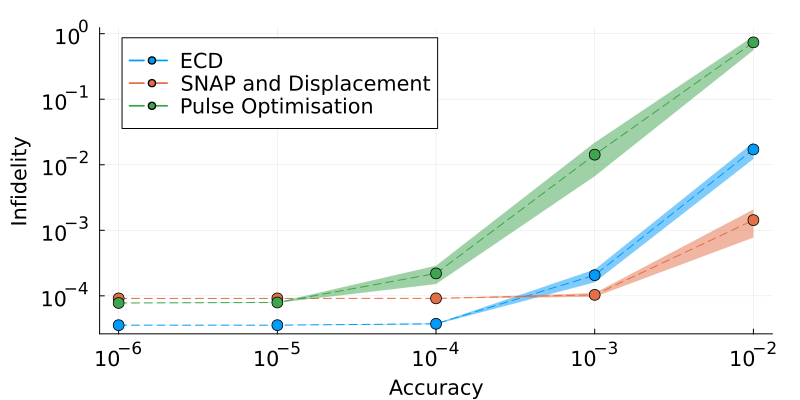

In [12]:
plot([1e-6, 1e-5,1e-4,1e-3, 1e-2],[non_perturbed, mean(perturbed_costs_5),mean(perturbed_costs_4),mean(perturbed_costs_3),mean(perturbed_costs_2)], ribbon = [0, std(perturbed_costs_5),std(perturbed_costs_4),std(perturbed_costs_3), std(perturbed_costs_2)],label= "ECD", xlabel="Accuracy", ylabel="Infidelity", fmt = :PDF, size=(800,400), margin=5mm, formatter = :plain, xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14, linestyle=:dash, marker = :circle, yaxis=:log, xaxis=:log, legend=:topleft, markersize = 6)
plot!([1e-6, 1e-5,1e-4,1e-3, 1e-2],[non_perturbed_snap, mean(perturbed_costs_5_snap),mean(perturbed_costs_4_snap),mean(perturbed_costs_3_snap),mean(perturbed_costs_2_snap)], ribbon = [0, std(perturbed_costs_5_snap),std(perturbed_costs_4_snap),std(perturbed_costs_3_snap), std(perturbed_costs_2_snap)],label= "SNAP and Displacement", xlabel="Accuracy", ylabel="Infidelity", fmt = :PDF, margin=5mm, formatter = :plain, xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14, linestyle=:dash, marker = :circle, yaxis=:log, xaxis=:log, markersize = 6)
plot!([1e-6, 1e-5,1e-4,1e-3, 1e-2],[non_perturbed_po,mean(perturbed_costs_5_po),mean(perturbed_costs_4_po),mean(perturbed_costs_3_po),mean(perturbed_costs_2_po)], ribbon = [0, std(perturbed_costs_5_po),std(perturbed_costs_4_po),std(perturbed_costs_3_po), std(perturbed_costs_2_po)],label= "Pulse Optimisation", xlabel="Accuracy", ylabel="Infidelity", fmt = :PDF, margin=5mm, formatter = :plain, xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14, linestyle=:dash, marker = :circle, yaxis=:log, xaxis=:log, markersize = 6)